In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-10-07 23:42:17.943973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 23:42:18.848700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0, 
    subset=None, build_tfrecords=False)

2023-10-07 23:42:21.265824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-07 23:42:21.346515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-07 23:42:21.346758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(batch_size, learning_rate=5e-4, mask_max_len=500)

In [4]:
mlp.train(dataset.train_data, dataset.valid_data)

2023-10-07 23:42:27.880187: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1447936000 exceeds 10% of free system memory.
2023-10-07 23:42:29.349582: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1447936000 exceeds 10% of free system memory.
2023-10-07 23:42:34.376423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-07 23:42:34.383713: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f233224c530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 23:42:34.383920: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-07 23:42:34.399792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to

iteration 100 training loss 1.3482306 lr 0.00050
iteration 200 training loss 1.3291728 lr 0.00050
iteration 300 training loss 1.3040167 lr 0.00050
iteration 400 training loss 1.3274386 lr 0.00050
iteration 500 training loss 1.1975561 lr 0.00050
iteration 600 training loss 1.1489128 lr 0.00050
iteration 700 training loss 1.0346915 lr 0.00050
iteration 800 training loss 1.1466416 lr 0.00050
iteration 900 training loss 1.286201 lr 0.00050
iteration 1000 training loss 1.1631628 lr 0.00050
iteration 1100 training loss 1.1424394 lr 0.00050
iteration 1200 training loss 1.228657 lr 0.00050
iteration 1300 training loss 1.0136105 lr 0.00050
iteration 1400 training loss 1.2040591 lr 0.00050
iteration 1500 training loss 1.0876817 lr 0.00050
iteration 1600 training loss 1.2141 lr 0.00050
iteration 1700 training loss 0.9309182 lr 0.00050
iteration 1800 training loss 0.999359 lr 0.00050
iteration 1900 training loss 0.97178775 lr 0.00050
iteration 2000 training loss 1.0314639 lr 0.00050
iteration 2100

iteration 16400 training loss 0.96695536 lr 0.00050
iteration 16500 training loss 1.1433299 lr 0.00050
iteration 16600 training loss 1.0104624 lr 0.00050
iteration 16700 training loss 0.929353 lr 0.00050
iteration 16800 training loss 0.7874842 lr 0.00050
iteration 16900 training loss 0.80443764 lr 0.00050
iteration 17000 training loss 0.9229065 lr 0.00050
iteration 17100 training loss 0.9037707 lr 0.00050
iteration 17200 training loss 0.934561 lr 0.00050
iteration 17300 training loss 0.99747014 lr 0.00050
iteration 17400 training loss 0.8768823 lr 0.00050
iteration 17500 training loss 0.7806146 lr 0.00050
iteration 17600 training loss 0.79353046 lr 0.00050
iteration 17700 training loss 1.0839518 lr 0.00050
iteration 17800 training loss 0.75374347 lr 0.00050
iteration 17900 training loss 1.0253435 lr 0.00050
iteration 18000 training loss 0.8886516 lr 0.00050
iteration 18100 training loss 1.0223576 lr 0.00050
iteration 18200 training loss 0.825696 lr 0.00050
iteration 18300 training loss

iteration 32100 training loss 1.0308603 lr 0.00045
iteration 32200 training loss 0.80950063 lr 0.00045
iteration 32300 training loss 0.9416916 lr 0.00045
iteration 32400 training loss 1.0476305 lr 0.00045
iteration 32500 training loss 0.8483855 lr 0.00045
iteration 32600 training loss 0.85070837 lr 0.00045
iteration 32700 training loss 0.9059016 lr 0.00045
iteration 32800 training loss 0.8930475 lr 0.00045
iteration 32900 training loss 0.9226707 lr 0.00045
iteration 33000 training loss 0.95581293 lr 0.00045
iteration 33100 training loss 0.81659967 lr 0.00045
iteration 33200 training loss 0.7975944 lr 0.00045
iteration 33300 training loss 0.8379138 lr 0.00045
iteration 33400 training loss 0.93964773 lr 0.00045
iteration 33500 training loss 0.8524838 lr 0.00045
iteration 33600 training loss 0.7694763 lr 0.00045
iteration 33700 training loss 0.8920278 lr 0.00045
iteration 33800 training loss 1.0733457 lr 0.00045
iteration 33900 training loss 0.8472372 lr 0.00045
iteration 34000 training l

iteration 47800 training loss 0.8188848 lr 0.00040
iteration 47900 training loss 0.9231073 lr 0.00040
iteration 48000 training loss 0.86118287 lr 0.00040
iteration 48100 training loss 0.8155749 lr 0.00040
iteration 48200 training loss 0.71771425 lr 0.00040
iteration 48300 training loss 0.86801106 lr 0.00040
iteration 48400 training loss 0.7927539 lr 0.00040
iteration 48500 training loss 0.941806 lr 0.00040
iteration 48600 training loss 0.85758334 lr 0.00040
iteration 48700 training loss 0.8669979 lr 0.00040
iteration 48800 training loss 0.87585914 lr 0.00040
iteration 48900 training loss 0.92879045 lr 0.00040
iteration 49000 training loss 0.9286512 lr 0.00040
iteration 49100 training loss 0.9065155 lr 0.00040
iteration 49200 training loss 0.707858 lr 0.00040
iteration 49300 training loss 0.87216675 lr 0.00040
iteration 49400 training loss 0.8802354 lr 0.00040
iteration 49500 training loss 0.81945217 lr 0.00040
iteration 49600 training loss 0.9741753 lr 0.00040
iteration 49700 training 

iteration 63400 training loss 0.6827587 lr 0.00036
iteration 63500 training loss 0.7919746 lr 0.00036
iteration 63600 training loss 0.7677223 lr 0.00036
iteration 63700 training loss 0.82590336 lr 0.00036
iteration 63800 training loss 0.62756836 lr 0.00036
iteration 63900 training loss 0.6537417 lr 0.00036
iteration 64000 training loss 0.9245458 lr 0.00036
iteration 64100 training loss 0.8611059 lr 0.00036
iteration 64200 training loss 0.9193798 lr 0.00036
iteration 64300 training loss 0.85018593 lr 0.00036
iteration 64400 training loss 0.91275704 lr 0.00036
iteration 64500 training loss 0.73935306 lr 0.00036
iteration 64600 training loss 1.0529335 lr 0.00036
iteration 64700 training loss 0.81776696 lr 0.00036
iteration 64800 training loss 1.0991868 lr 0.00036
iteration 64900 training loss 0.85230947 lr 0.00036
iteration 65000 training loss 0.91884375 lr 0.00036
iteration 65100 training loss 0.72627634 lr 0.00036
iteration 65200 training loss 1.0928249 lr 0.00036
iteration 65300 traini

iteration 79400 training loss 0.8728372 lr 0.00036
iteration 79500 training loss 0.8523296 lr 0.00036
iteration 79600 training loss 0.6844663 lr 0.00036
iteration 79700 training loss 0.82244265 lr 0.00036
iteration 79800 training loss 0.8755283 lr 0.00036
iteration 79900 training loss 0.8389093 lr 0.00036
iteration 80000 training loss 0.99056464 lr 0.00036
layout:nlp:random 0.7566149938362464
layout:nlp:default 0.3909815353830071
layout:xla:random 0.463475402628455
layout:xla:default 0.16501829873555904
epoch 0, it 80000 validation loss -0.444
iteration 80100 training loss 1.040007 lr 0.00033
iteration 80200 training loss 0.6510828 lr 0.00033
iteration 80300 training loss 0.8395504 lr 0.00033
iteration 80400 training loss 0.6982411 lr 0.00033
iteration 80500 training loss 0.78682125 lr 0.00033
iteration 80600 training loss 0.8924037 lr 0.00033
iteration 80700 training loss 0.76094586 lr 0.00033
iteration 80800 training loss 0.79122895 lr 0.00033
iteration 80900 training loss 0.7200631 

iteration 95000 training loss 0.74917644 lr 0.00033
iteration 95100 training loss 0.793849 lr 0.00033
iteration 95200 training loss 0.7791266 lr 0.00033
iteration 95300 training loss 0.6504948 lr 0.00033
iteration 95400 training loss 0.65666 lr 0.00033
iteration 95500 training loss 0.7323087 lr 0.00033
iteration 95600 training loss 0.59826535 lr 0.00033
iteration 95700 training loss 0.6004999 lr 0.00033
iteration 95800 training loss 0.78085065 lr 0.00033
iteration 95900 training loss 0.81290805 lr 0.00033
iteration 96000 training loss 0.7009763 lr 0.00033
iteration 96100 training loss 0.6480862 lr 0.00033
iteration 96200 training loss 0.7303793 lr 0.00033
iteration 96300 training loss 0.86652505 lr 0.00033
iteration 96400 training loss 0.7994003 lr 0.00033
iteration 96500 training loss 0.86149263 lr 0.00033
iteration 96600 training loss 0.6780917 lr 0.00033
iteration 96700 training loss 0.9354434 lr 0.00033
iteration 96800 training loss 0.94310796 lr 0.00033
iteration 96900 training lo

iteration 110400 training loss 0.70259297 lr 0.00030
iteration 110500 training loss 0.85963523 lr 0.00030
iteration 110600 training loss 0.768442 lr 0.00030
iteration 110700 training loss 0.8665566 lr 0.00030
iteration 110800 training loss 0.8579092 lr 0.00030
iteration 110900 training loss 0.9058286 lr 0.00030
iteration 111000 training loss 0.89910656 lr 0.00030
iteration 111100 training loss 0.70246166 lr 0.00030
iteration 111200 training loss 0.74773103 lr 0.00030
iteration 111300 training loss 0.65951276 lr 0.00030
iteration 111400 training loss 0.702297 lr 0.00030
iteration 111500 training loss 0.718611 lr 0.00030
iteration 111600 training loss 0.7935173 lr 0.00030
iteration 111700 training loss 0.6623615 lr 0.00030
iteration 111800 training loss 0.68761986 lr 0.00030
iteration 111900 training loss 0.7269557 lr 0.00030
iteration 112000 training loss 0.74067175 lr 0.00030
iteration 112100 training loss 1.0323284 lr 0.00030
iteration 112200 training loss 0.7988894 lr 0.00030
iterati

iteration 125700 training loss 0.92953557 lr 0.00027
iteration 125800 training loss 0.66600895 lr 0.00027
iteration 125900 training loss 0.7508439 lr 0.00027
iteration 126000 training loss 0.93010443 lr 0.00027
iteration 126100 training loss 0.6281618 lr 0.00027
iteration 126200 training loss 0.8364783 lr 0.00027
iteration 126300 training loss 0.7217508 lr 0.00027
iteration 126400 training loss 0.7142872 lr 0.00027
iteration 126500 training loss 0.7098856 lr 0.00027
iteration 126600 training loss 0.60771704 lr 0.00027
iteration 126700 training loss 0.6426492 lr 0.00027
iteration 126800 training loss 0.69864196 lr 0.00027
iteration 126900 training loss 0.8170129 lr 0.00027
iteration 127000 training loss 0.6541492 lr 0.00027
iteration 127100 training loss 0.84495825 lr 0.00027
iteration 127200 training loss 0.8324816 lr 0.00027
iteration 127300 training loss 0.6716848 lr 0.00027
iteration 127400 training loss 0.7071216 lr 0.00027
iteration 127500 training loss 0.63765323 lr 0.00027
itera

iteration 141000 training loss 0.7068497 lr 0.00024
iteration 141100 training loss 0.719588 lr 0.00024
iteration 141200 training loss 0.7551401 lr 0.00024
iteration 141300 training loss 0.6685441 lr 0.00024
iteration 141400 training loss 0.793195 lr 0.00024
iteration 141500 training loss 0.5926173 lr 0.00024
iteration 141600 training loss 0.8782683 lr 0.00024
iteration 141700 training loss 0.64135945 lr 0.00024
iteration 141800 training loss 0.73302174 lr 0.00024
iteration 141900 training loss 0.6182794 lr 0.00024
iteration 142000 training loss 0.735648 lr 0.00024
iteration 142100 training loss 0.8068293 lr 0.00024
iteration 142200 training loss 0.7095306 lr 0.00024
iteration 142300 training loss 0.57718956 lr 0.00024
iteration 142400 training loss 0.5834407 lr 0.00024
iteration 142500 training loss 0.5402183 lr 0.00024
iteration 142600 training loss 0.6893199 lr 0.00024
iteration 142700 training loss 0.5868073 lr 0.00024
iteration 142800 training loss 0.77963585 lr 0.00024
iteration 1

iteration 156700 training loss 0.7542779 lr 0.00024
iteration 156800 training loss 0.69784784 lr 0.00024
iteration 156900 training loss 0.6436925 lr 0.00024
iteration 157000 training loss 0.8072392 lr 0.00024
iteration 157100 training loss 0.74878496 lr 0.00024
iteration 157200 training loss 0.7448007 lr 0.00024
iteration 157300 training loss 0.6629867 lr 0.00024
iteration 157400 training loss 0.73895955 lr 0.00024
iteration 157500 training loss 0.7951522 lr 0.00024
iteration 157600 training loss 0.88491046 lr 0.00024
iteration 157700 training loss 0.58187515 lr 0.00024
iteration 157800 training loss 0.86281496 lr 0.00024
iteration 157900 training loss 0.6180664 lr 0.00024
iteration 158000 training loss 0.61202824 lr 0.00024
iteration 158100 training loss 0.671061 lr 0.00024
iteration 158200 training loss 0.71801984 lr 0.00024
iteration 158300 training loss 0.67019784 lr 0.00024
iteration 158400 training loss 0.5885588 lr 0.00024
iteration 158500 training loss 0.5969853 lr 0.00024
iter

iteration 172000 training loss 0.7148115 lr 0.00022
iteration 172100 training loss 0.62420464 lr 0.00022
iteration 172200 training loss 0.7571539 lr 0.00022
iteration 172300 training loss 0.5957254 lr 0.00022
iteration 172400 training loss 0.57165974 lr 0.00022
iteration 172500 training loss 0.68335545 lr 0.00022
iteration 172600 training loss 0.7159439 lr 0.00022
iteration 172700 training loss 0.6162562 lr 0.00022
iteration 172800 training loss 0.5184195 lr 0.00022
iteration 172900 training loss 0.61332834 lr 0.00022
iteration 173000 training loss 0.72659314 lr 0.00022
iteration 173100 training loss 0.7728555 lr 0.00022
iteration 173200 training loss 0.85452944 lr 0.00022
iteration 173300 training loss 0.95761544 lr 0.00022
iteration 173400 training loss 0.8581638 lr 0.00022
iteration 173500 training loss 0.72667 lr 0.00022
iteration 173600 training loss 0.61457086 lr 0.00022
iteration 173700 training loss 0.5651269 lr 0.00022
iteration 173800 training loss 0.68405473 lr 0.00022
itera

iteration 187300 training loss 0.6589648 lr 0.00019
iteration 187400 training loss 0.5730493 lr 0.00019
iteration 187500 training loss 0.6885205 lr 0.00019
iteration 187600 training loss 0.62772846 lr 0.00019
iteration 187700 training loss 0.71795267 lr 0.00019
iteration 187800 training loss 0.53813 lr 0.00019
iteration 187900 training loss 0.74252254 lr 0.00019
iteration 188000 training loss 0.5128956 lr 0.00019
iteration 188100 training loss 0.72311723 lr 0.00019
iteration 188200 training loss 0.63284767 lr 0.00019
iteration 188300 training loss 0.86406374 lr 0.00019
iteration 188400 training loss 0.84983927 lr 0.00019
iteration 188500 training loss 0.83003265 lr 0.00019
iteration 188600 training loss 0.7603096 lr 0.00019
iteration 188700 training loss 0.7085623 lr 0.00019
iteration 188800 training loss 0.8641589 lr 0.00019
iteration 188900 training loss 0.65089333 lr 0.00019
iteration 189000 training loss 0.6861465 lr 0.00019
iteration 189100 training loss 0.8074794 lr 0.00019
itera

iteration 202600 training loss 0.55297285 lr 0.00017
iteration 202700 training loss 0.5677525 lr 0.00017
iteration 202800 training loss 0.629296 lr 0.00017
iteration 202900 training loss 0.7760787 lr 0.00017
iteration 203000 training loss 0.7477061 lr 0.00017
iteration 203100 training loss 0.60570556 lr 0.00017
iteration 203200 training loss 0.728659 lr 0.00017
iteration 203300 training loss 0.66279405 lr 0.00017
iteration 203400 training loss 1.0373855 lr 0.00017
iteration 203500 training loss 0.73457605 lr 0.00017
iteration 203600 training loss 0.7305053 lr 0.00017
iteration 203700 training loss 0.81076574 lr 0.00017
iteration 203800 training loss 0.80654883 lr 0.00017
iteration 203900 training loss 0.9636515 lr 0.00017
iteration 204000 training loss 0.7389885 lr 0.00017
iteration 204100 training loss 0.89773846 lr 0.00017
iteration 204200 training loss 0.65888286 lr 0.00017
iteration 204300 training loss 0.8568594 lr 0.00017
iteration 204400 training loss 0.765292 lr 0.00017
iterati

iteration 218300 training loss 0.8089887 lr 0.00017
iteration 218400 training loss 0.6662826 lr 0.00017
iteration 218500 training loss 0.63059735 lr 0.00017
iteration 218600 training loss 0.913736 lr 0.00017
iteration 218700 training loss 0.7592323 lr 0.00017
iteration 218800 training loss 0.62728 lr 0.00017
iteration 218900 training loss 0.6626117 lr 0.00017
iteration 219000 training loss 0.7785107 lr 0.00017
iteration 219100 training loss 0.9122048 lr 0.00017
iteration 219200 training loss 0.5701523 lr 0.00017
iteration 219300 training loss 0.79780865 lr 0.00017
iteration 219400 training loss 0.9227277 lr 0.00017
iteration 219500 training loss 0.8820451 lr 0.00017
iteration 219600 training loss 0.7440319 lr 0.00017
iteration 219700 training loss 0.6716883 lr 0.00017
iteration 219800 training loss 0.7936947 lr 0.00017
iteration 219900 training loss 0.8431261 lr 0.00017
iteration 220000 training loss 0.7089483 lr 0.00017
layout:nlp:random 0.8057465279785969
layout:nlp:default 0.4220349

iteration 233600 training loss 0.87733567 lr 0.00016
iteration 233700 training loss 0.8411595 lr 0.00016
iteration 233800 training loss 0.71897084 lr 0.00016
iteration 233900 training loss 0.7604808 lr 0.00016
iteration 234000 training loss 0.7871445 lr 0.00016
iteration 234100 training loss 0.8073729 lr 0.00016
iteration 234200 training loss 0.7779092 lr 0.00016
iteration 234300 training loss 0.7475126 lr 0.00016
iteration 234400 training loss 0.71258193 lr 0.00016
iteration 234500 training loss 0.7334283 lr 0.00016
iteration 234600 training loss 0.75366384 lr 0.00016
iteration 234700 training loss 0.6109296 lr 0.00016
iteration 234800 training loss 0.9141864 lr 0.00016
iteration 234900 training loss 0.95340866 lr 0.00016
iteration 235000 training loss 0.890307 lr 0.00016
iteration 235100 training loss 0.9732686 lr 0.00016
iteration 235200 training loss 0.6200659 lr 0.00016
iteration 235300 training loss 0.9304271 lr 0.00016
iteration 235400 training loss 0.6624161 lr 0.00016
iteratio

iteration 248900 training loss 0.8089574 lr 0.00014
iteration 249000 training loss 0.92060924 lr 0.00014
iteration 249100 training loss 0.81604666 lr 0.00014
iteration 249200 training loss 0.62410855 lr 0.00014
iteration 249300 training loss 0.8051528 lr 0.00014
iteration 249400 training loss 0.69037384 lr 0.00014
iteration 249500 training loss 0.59723467 lr 0.00014
iteration 249600 training loss 0.83230644 lr 0.00014
iteration 249700 training loss 0.83822906 lr 0.00014
iteration 249800 training loss 0.84956884 lr 0.00014
iteration 249900 training loss 0.7919425 lr 0.00014
iteration 250000 training loss 0.84338915 lr 0.00014
iteration 250100 training loss 0.8047674 lr 0.00014
iteration 250200 training loss 0.95234364 lr 0.00014
iteration 250300 training loss 0.7289329 lr 0.00014
iteration 250400 training loss 0.7396436 lr 0.00014
iteration 250500 training loss 0.6110736 lr 0.00014
iteration 250600 training loss 0.9141866 lr 0.00014
iteration 250700 training loss 0.97714716 lr 0.00014
i

iteration 264200 training loss 0.57917386 lr 0.00013
iteration 264300 training loss 0.74230695 lr 0.00013
iteration 264400 training loss 0.6348012 lr 0.00013
iteration 264500 training loss 0.5810783 lr 0.00013
iteration 264600 training loss 0.7010599 lr 0.00013
iteration 264700 training loss 0.81075644 lr 0.00013
iteration 264800 training loss 0.65579456 lr 0.00013
iteration 264900 training loss 0.69204897 lr 0.00013
iteration 265000 training loss 0.8046129 lr 0.00013
iteration 265100 training loss 0.67653626 lr 0.00013
iteration 265200 training loss 0.9429178 lr 0.00013
iteration 265300 training loss 0.70135283 lr 0.00013
iteration 265400 training loss 0.7563585 lr 0.00013
iteration 265500 training loss 0.7350637 lr 0.00013
iteration 265600 training loss 0.8977157 lr 0.00013
iteration 265700 training loss 0.5680526 lr 0.00013
iteration 265800 training loss 0.6035184 lr 0.00013
iteration 265900 training loss 0.6541412 lr 0.00013
iteration 266000 training loss 0.82511866 lr 0.00013
iter

iteration 279900 training loss 0.64847845 lr 0.00013
iteration 280000 training loss 0.77490443 lr 0.00013
layout:nlp:random 0.8095316519096183
layout:nlp:default 0.415086514681294
layout:xla:random 0.4978366376847672
layout:xla:default 0.1846724988505307
epoch 0, it 280000 validation loss -0.477
iteration 280100 training loss 0.78121775 lr 0.00011
iteration 280200 training loss 0.74429315 lr 0.00011
iteration 280300 training loss 0.6496787 lr 0.00011
iteration 280400 training loss 0.64641994 lr 0.00011
iteration 280500 training loss 0.68976647 lr 0.00011
iteration 280600 training loss 0.83473754 lr 0.00011
iteration 280700 training loss 0.81115645 lr 0.00011
iteration 280800 training loss 0.7978167 lr 0.00011
iteration 280900 training loss 0.7281265 lr 0.00011
iteration 281000 training loss 0.75635296 lr 0.00011
iteration 281100 training loss 0.70032305 lr 0.00011
iteration 281200 training loss 0.75312346 lr 0.00011
iteration 281300 training loss 0.76118153 lr 0.00011
iteration 281400 

KeyboardInterrupt: 

In [ ]:
mlp.normalization_layer_config_nodes.mean.numpy().flatten()

In [ ]:
plt.hist(mlp.dense_layer_3.kernel.numpy().flatten(), bins=50);

In [ ]:
for tile_ids, config_indexes, config_descriptors, valid_mask, graph_descriptor, normalized_runtimes in dataset.train_data:
    break

In [ ]:
np.unique(tile_ids.numpy())

In [ ]:
config_descriptors.numpy()[5, 0, :]

In [ ]:
config_descriptors

In [ ]:
import tensorflow as tf

In [ ]:
x = mlp.normalization_layer_config_nodes(config_descriptors)
x = mlp.dense_layer_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)

float_mask = tf.cast(valid_mask, tf.float32)  # (batch_size, n_config_nodes_upper_limit)
float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask
x = tf.reduce_mean(x, axis=1)

normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, normal_graph_descriptor], axis=-1)
x = mlp.dense_layer_2(x)
x = mlp.relu_layer(x)
x = mlp.dense_layer_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
order = np.random.permutation(np.arange(10))
new_order = order.copy()
new_order[0] = order[1]
new_order[1] = order[0]
kendalltau(order, new_order)

## Evaluate validation set

In [5]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

In [6]:
val_df[['prediction', 'target']].describe()

,prediction,target
count,492038.000000,492038.000000
mean,-2.118693,16.887459
std,54.993702,2.029978
min,-167.809280,13.622271
25%,-18.549092,15.501094
50%,9.116626,16.255013
75%,29.061701,17.911939
max,101.065628,23.752274


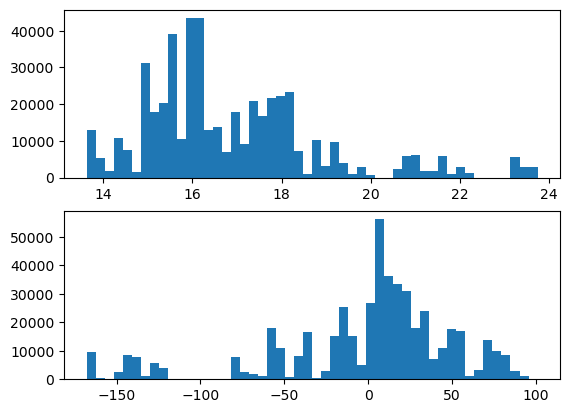

In [7]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [8]:
val_df.ID.unique()

array([b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test',
       b'layout:xla:default:unet_3d.4x4.bf16',
       b'layout:nlp:random:albert_en_xlarge_batch_size_16_test',
       b'layout:xla:random:resnet50.4x4.fp16',
       b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test',
       b'layout:xla:random:inception_v3_batch_128_train',
       b'layout:nlp:random:small_bert_bert_en_uncased_L-2_H-256_A-4_batch_size_32_train',
       b'layout:xla:default:mlperf_bert_batch_24_2x2',
       b'layout:nlp:default:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',
       b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_32_test',
       b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train',
       b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-256_A-4_batch_size_32_train',
       b'layout:nlp:default:albert_en_xlarge_batch_size_16_test',
       b'layout:nlp:rando

Text(0.5, 1.0, "b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'")

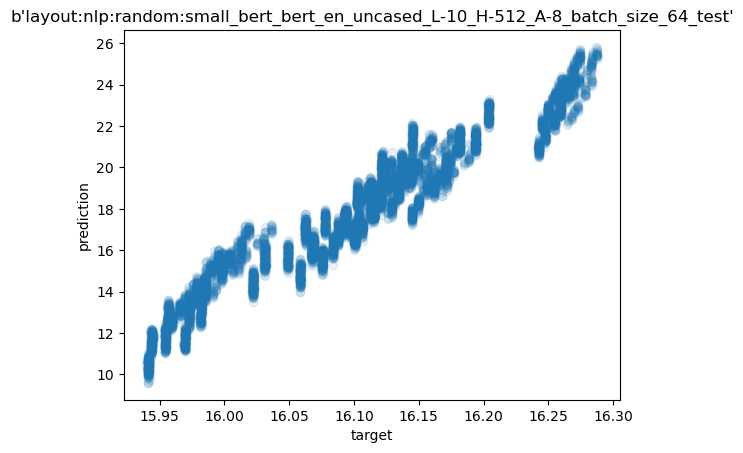

In [30]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(10_000)
graph_id = np.random.choice(val_df['ID'].unique())
random_sample = val_df[val_df['ID'] == graph_id]

plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-10000.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [31]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               51243;38779;36787;48225;26190;4124;30988;6227;...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  21836;952;74994;64836;18698;74993;64159;74987;...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              7170;7163;15580;7156;15831;15831;20081;20081;2...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      14029;69717;69717;88324;88293;88034;58542;6216...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     7777;44452;44452;30639;7735;41500;12989;50684;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      1538;1544;1544;1947;1563;54992;7664;1931;1900;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     25715;23244;26904;41464;41476;41455;41468;2561...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [ ]:
val_df

In [ ]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

In [ ]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

In [ ]:
np.mean([0.368, 0.137, 0.738, 0.346, 0.85])

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [32]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:xla:random:3e7156ac468dfb75cf5c9615e1...,1,-109.468857
1,b'layout:xla:random:3e7156ac468dfb75cf5c9615e1...,2,-101.939209
2,b'layout:xla:random:3e7156ac468dfb75cf5c9615e1...,19,-109.803253
3,b'layout:xla:random:3e7156ac468dfb75cf5c9615e1...,17,-117.019867
4,b'layout:xla:random:3e7156ac468dfb75cf5c9615e1...,15,-110.746201
...,...,...,...
49997,b'layout:nlp:random:f6c146fc5cf10be4f3accbaca9...,956,23.913906
49998,b'layout:nlp:random:f6c146fc5cf10be4f3accbaca9...,936,25.535656
49999,b'layout:nlp:random:f6c146fc5cf10be4f3accbaca9...,995,28.096973
50000,b'layout:nlp:random:f6c146fc5cf10be4f3accbaca9...,971,20.557175


In [33]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    91;405;951;762;792;996;262;408;979;701;296;954...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    650;382;582;592;466;510;565;21;849;15;84;976;2...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    214;142;48;350;664;825;637;830;204;930;539;447...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    237;370;953;974;644;295;508;292;26;733;870;34;...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    772;692;935;483;543;161;313;327;226;133;790;63...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    136;997;524;383;736;917;35;406;114;129;378;589...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    518;202;222;492;466;308;293;947;774;585;506;53...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    11;630;931;634;91;483;24;487;827;545;755;766;5...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    499;903;300;844;751;429;444;61;642;328;583;780...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [34]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('layout_none_test_prediction_10_08_01_31.csv')

In [ ]:
plt.hist(np.abs(mlp.dense_layer_1.kernel.numpy().flatten()), bins=50)